In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\JingYou\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [249]:
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 60
TIME_STEP = 5

In [250]:
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
# def load_data(date_begin='20180612', date_end = '20180730', split_date_begin = '20180801', split_date_end = '20180830', train = True):

    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "close"]
                if len(front_df) == (total_mins // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

# def dtw_d(X, Y):
#     manhattan_distance = lambda x, y: np.abs(x - y)
#     d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
#     return d

# def dtw_affinity(X):
#     return pairwise_distances(X, metric=dtw_d)

# def fastdtw_d(X, Y):
#     return fastdtw(X, Y, dist=euclidean)[0]

# def fastdtw_affinity(X):
#     return pairwise_distances(X, metric=fastdtw_d)

def show_clustering():
    for n in range(NUM_CLUSTER):
        plt.title(n)
        for i in range(len(X)):
        #     plt.subplot(10, 1, X_label[i]+1)
            if X_label[i] == n:
                plt.plot(X[i])
        plt.show()
def train(max_iter = 300, n_clusters = 50):
    t1 = time.time()
    km = TimeSeriesKMeans(max_iter = max_iter, n_clusters=n_clusters, metric="dtw", n_jobs=5)
    X_label = km.fit_predict(X)
    t2 = time.time()
    print("training time", t2-t1)
    return km

def make_long_simple(y, cost):
    return y.max(),   y[0] * (1 + cost)
def make_short_simple(y, cost):
    return y[0], y.min() * (1 + cost)
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0], - y.max() - cost

def make_long(y, cost, exp_profit):
    if (y- (y[0] * (1+cost)) >= exp_profit).any():
        return y[0] *( 1 + exp_profit),   y[0] * (1 + cost)
    else:
        return y[-1],   y[0] * (1 + cost)
    
def make_short(y, cost, exp_profit):
    if (y[0] - y >=  y[0] * (exp_profit + cost)).any():
        return y[0] * (1-cost), y[0] * (1-exp_profit) 
    else:
        return y[0] * (1-cost), y[-1]
    
def evaluate_km(X_test, Y_test, X_label, exp_profit=0.025):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    cost_long_array = np.zeros(NUM_CLUSTER)
    cost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
    #     p, l = make_long_simple(Y[i], 0.002)
    #     profit_long_array[X_label[i]] += p
    #     cost_short_array[X_label[i]] += l
        p, l = make_short(Y_test[i], 0.002, exp_profit)
        profit_short_array[X_label[i]] += p
        cost_short_array[X_label[i]] += l
        num_exchange_array[X_label[i]] += 1

    return profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array

In [251]:
X, Y = load_data()

100%|██████████| 13/13 [00:16<00:00,  1.28s/it]


In [252]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


In [253]:
print(X.shape)

(2990, 19)


In [254]:
print(X_test.shape)

(915, 19)


t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [255]:
km = train(n_clusters = NUM_CLUSTER)

training time 257.82679748535156


In [264]:
X_label = km.predict(X)

C:\Users\JingYou\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2990 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [265]:
X_label

array([27, 50, 27, ..., 13, 40, 46], dtype=int64)

pickle.dump(X, open(os.path.join('dataset_pk',"X_ts.pk"), "wb"))
pickle.dump(Y, open(os.path.join('dataset_pk',"Y_ts.pk"), "wb"))


In [211]:
# show_clustering()

def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open(os.path.join('dataset_pk',"X_ts_tabel.pk"), "wb"))

In [31]:
len(X)

2990

In [132]:
Y.shape

(2990,)

In [256]:
pickle.dump(km, open("km.pk", 'wb'))

km = pickle.load(open("km.pk", 'rb'))

km = pickle.load(open("km.pk", 'rb'))
X = pickle.load(open(os.path.join('dataset_pk',"X_ts.pk"), 'rb'))
Y = pickle.load(open(os.path.join('dataset_pk',"Y_ts.pk"), 'rb'))
X_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))
Y_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))

X_label

# 樣本內

In [324]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
cost_long_array = np.zeros(NUM_CLUSTER)
cost_short_array = np.zeros(NUM_CLUSTER)
num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    p, l = make_short(Y[i], 0.002, 0.03)
    profit_short_array[X_label[i]] += p
    cost_short_array[X_label[i]] += l
    num_exchange_array[X_label[i]] += 1
# print("0.025" ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])
best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]

avg_sin_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
avg_sin_profit[np.isnan(avg_profit)] = 0
s = 0
n = 0
for i in range(len(best_short_cluster)):
    s += avg_sin_profit[j] * num_exchange_array[j]
    n += num_exchange_array[best_short_cluster[i]]
#     print(best_short_cluster[i], avg_sin_profit[best_short_cluster[i]], n)

print(s/n)

6.295151556478731e-05


In [267]:
print(best_short_cluster)

[51 52 30 49 27 17  4 25 14 15 28  3 10 40 18 59  2 50  5 20 13  9 41 55
  8 11 12 23 57 34 29 36 58  6 24 31 39 46 21 33 43 38 16 47 56 26 53 45
 48 35 22 54 42  1 32  7 44 19 37  0]


# 樣本外

In [268]:
y_test_pred =  km.predict(X_test.reshape(len(X_test), len(X_test[0]), 1))

In [310]:
profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array = evaluate_km(X_test, Y_test, y_test_pred, exp_profit=0.01)
avg_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
avg_profit[np.isnan(avg_profit)] = 0
for i in range(len(best_short_cluster)):
    n = num_exchange_array[best_short_cluster[i]]
    print(best_short_cluster[i], avg_profit[best_short_cluster[i]], n)

51 0.004040404040404072 2
30 0.008080808080808112 1
4 0.00020370593301167502 14
14 0.0015415959252971401 2
27 0.0 0
28 0.0003424392783610947 14
10 0.0003985463419758769 7
3 -1.7411796361828142e-05 13
49 0.004040404040404136 2
50 0.0005450176866283926 11
18 5.5644250466345856e-05 38
40 0.00011597265817074884 24
2 -0.00024164786897685328 14
9 -4.043162077015009e-05 40
5 -0.00014100426994878516 40
55 -0.00013695196602948187 29
11 -0.00015909756093823957 39
13 -0.00011560384825290449 27
43 -0.00016806760885396544 11
20 -0.0007116426955690936 13
12 -1.197476810610594e-05 49
23 -7.3191252424562e-05 38
25 0.0001779242363790752 21
15 0.000734618916437119 11
41 -0.00012240239133635836 27
29 -2.1617768387104852e-05 44
57 -1.0180972041066395e-05 32
44 -0.0014523706620661466 11
36 0.0003181466525390525 17
8 -0.00025400917136846984 16
31 -0.0003157657679290466 22
6 -0.0013801913644680397 7
58 -0.0008888913164024712 15
39 -0.00016302767665308518 34
33 -0.00035380061643722525 8
46 -6.372238978349213e

C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [311]:
s = 0
n = 0
for i in range(5):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.0011629837407565256


In [312]:
s = 0
n = 0
for i in range(10):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.0006595502219132921


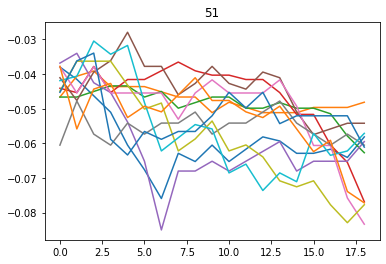

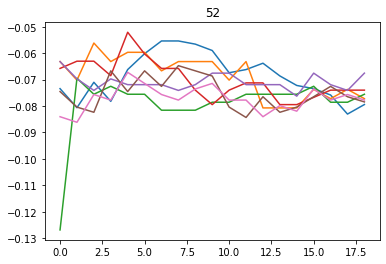

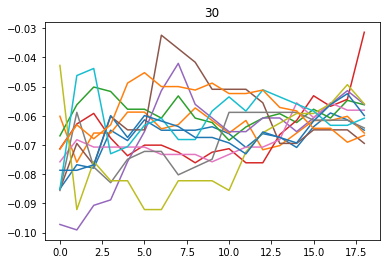

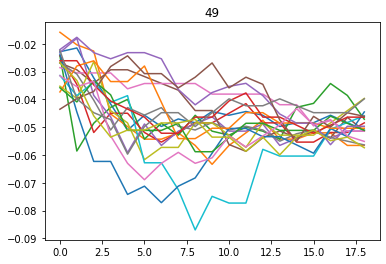

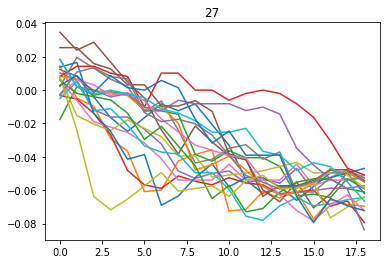

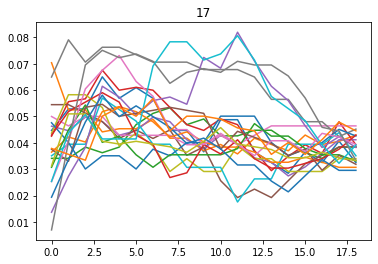

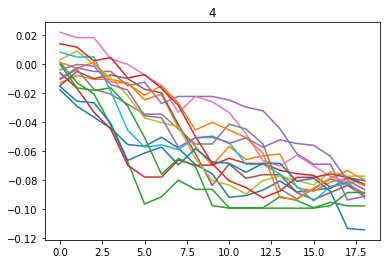

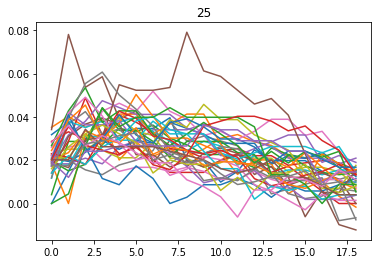

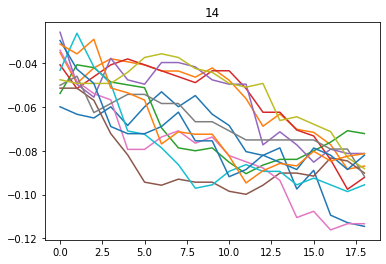

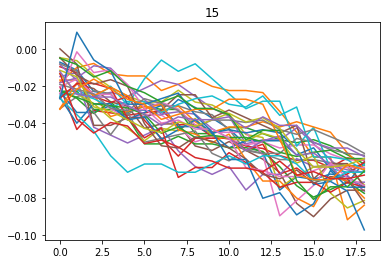

In [272]:
for n in range(10):
    plt.title(best_short_cluster[n])
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == best_short_cluster[n]:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()